# Goal:

The goal of this program is to dive a bit deeper into the process of figuring out what function best models the dependencies, how to best correct them, and whether they should be weighted. We will start with using some data from test 1a in the BalrogTests file since that uses galaxies which has a larger data set and has greater dependencies on the survey properties.

# WEDNESDAY:

Just double check that PCA is actually being done correctly. Maybe check with a simple example of like an y=x curve with small added noise. Then, run a complete run with iterative approaches, ending when no individual component is above 0.01. After this, look at the 2d histogram relationships and compare to original relationships in terms of variance from average.

It is clear that of the five methods I'm testing, there is some variation in which fitting method actually provides the best correction. Maybe try bootstrap sampling on 10 bins something like 100 times to get a bunch of other realizations. Use these to pick which method works best? Check if this passes the smell test. It could also be useful to check for coupling at this point. This could be done by reading in a map, applying a correction based on it, and then checking pre/post dependencies on the other PC maps. If they are completely decoupled, I don't think the dependencies should change.

In [1]:
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import BalrogTestConfig as balrConfig
import Config
from TrainAndFullMap import *

In [2]:
sigma = balrConfig.sigma
perVar = balrConfig.perVar
perMap = balrConfig.perMap
numBins = balrConfig.numBins
perCovered = balrConfig.perCovered

In [3]:
detBalrStarFile = balrConfig.detBalrStarFile
detBalrGalaFile = balrConfig.detBalrGalaFile

deepFiles = balrConfig.deepFiles

origCondFiles = balrConfig.origCondFiles
stelFile = balrConfig.stelFile

In [4]:
test1aRes = balrConfig.test1aRes
test1aMagBin = balrConfig.test1aMagBin

test1aAllPixFile = balrConfig.test1aAllPixFile
test1aGalaFile = balrConfig.test1aGalaFile
test1aValidPixFile = balrConfig.test1aValidPixFile

test1aCondFiles = balrConfig.test1aCondFiles

test1aTrainFile = balrConfig.test1aTrainFile
test1aProbFile = balrConfig.test1aProbFile
test1aExtrFile = balrConfig.test1aExtrFile

In [5]:
validPix = fitsio.read(test1aValidPixFile)['PIXEL']

In [6]:
detData = fitsio.read(test1aGalaFile)

In [7]:
allData = fitsio.read(test1aAllPixFile)

In [8]:
detPix = hp.ang2pix(test1aRes, detData['RA'], detData['DEC'], nest = True, lonlat = True)

In [9]:
_, detPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
detPixCounts = detPixCounts - 1

In [10]:
# condMaps = []

# # This loops over every condition file
# for condFile in test1aCondFiles:
#     condData = fitsio.read(condFile) # This reads in the data
#     condMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

# condMaps = np.array(condMaps, dtype = object) # Converts to an array

# means = []
# stds = []
# # This will hold every standardized map
# stanMaps = []
# # This standardizes every map as a first step of PCA
# for j in range(len(condMaps)):
#     # Store mean and std dev for later use.
#     means.append(np.average(condMaps[j]))
#     stds.append(np.std(condMaps[j]))
#     stanMaps.append((condMaps[j] - np.average(condMaps[j])) / np.std(condMaps[j]))

# stanMaps = np.array(stanMaps)

# # This gives the covariance matrix of the standardized maps
# # Bias is true since the variance of each individual standardized map should be 1
# cov = np.cov(stanMaps.astype(float), bias = True)

# # This gives the eigenvalues and vectors of the covariance matrix
# evalues, evectors = np.linalg.eig(cov)

# # This cuts after the specified percentage of the variance has been achieved
# for j in range(len(evalues)):
#     if np.sum(evalues[0:j+1]) / np.sum(evalues) >= perVar:
#         cutoff = j + 1
#         break
# featVec = evectors[0:cutoff]

# redMaps = np.matmul(featVec, stanMaps) # Reduces the maps to PCA maps

# # Standard deviations will once more be stored for later use.
# # Maps are reduced to standard deviation of 1 for consistent x values in the following steps.
# redStds = []
# for j in np.arange(len(redMaps)):
#     redStds.append(np.std(redMaps[j]))
#     redMaps[j] = redMaps[j]/np.std(redMaps[j])

In [11]:
PCA_Store_File = balrConfig.test1aDir + 'PCA_Maps.fits'

In [12]:
# my_table = Table()
# for i in range(len(redMaps)):
#     my_table[str(i)] = redMaps[i].astype('float')
# my_table.write(PCA_Store_File, overwrite = True)

In [13]:
PC_Maps = fitsio.read(PCA_Store_File)

In [14]:
PC_Index = str(16)

In [15]:
PC_Map = PC_Maps[PC_Index]
sortedPC = np.sort(PC_Map)

PC_Map_2 = PC_Maps['17']

# PC_Map_2 = PC_Map_2[np.where((PC_Map >= sortedPC[int(0.005 * len(sortedPC))]) & (PC_Map <= sortedPC[int(0.995 * len(sortedPC))]))[0]]

# detPixCounts = detPixCounts[np.where((PC_Map >= sortedPC[int(0.005 * len(sortedPC))]) & (PC_Map <= sortedPC[int(0.995 * len(sortedPC))]))[0]]
# PC_Map = PC_Map[np.where((PC_Map >= sortedPC[int(0.005 * len(sortedPC))]) & (PC_Map <= sortedPC[int(0.995 * len(sortedPC))]))[0]]

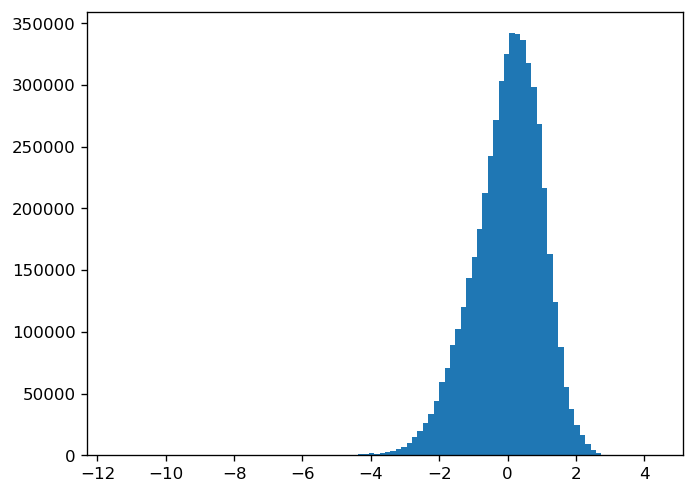

In [16]:
plt.figure(dpi = 120)
plt.hist(PC_Maps[PC_Index], bins = np.linspace(np.min(PC_Map), np.max(PC_Map), 101))
plt.show()

## Binning Method

In [17]:
binsApproachNum = 10
    
binIndLims = [0]

for j in range(binsApproachNum):
    binIndLims.append(int((len(PC_Map) - binIndLims[-1]) / (binsApproachNum - j)) + (binIndLims[-1]))

sortInds = PC_Map.argsort()
PC_Map_Sort = PC_Map[sortInds[::1]]
detStarTemp = detPixCounts[sortInds[::1]]

detBins = []
pcBins = []

for j in range(binsApproachNum):
    detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
    pcBins.append(PC_Map_Sort[binIndLims[j]:binIndLims[j+1]])
    
aveDet = np.sum(detPixCounts) / len(detPixCounts)

yBin = []
xBin = []

for j in range(binsApproachNum):
    yBin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
    xBin.append(np.sum(pcBins[j]) / len(pcBins[j]))

xBin = np.array(xBin)
yBin = np.array(yBin)

In [18]:
sortInds_2 = PC_Map_2.argsort()
PC_Map_2_Sort = PC_Map_2[sortInds_2[::1]]
detStarTemp = detPixCounts[sortInds_2[::1]]

detBins = []
pcBins_2 = []

for j in range(binsApproachNum):
    detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
    pcBins_2.append(PC_Map_2_Sort[binIndLims[j]:binIndLims[j+1]])
    
aveDet = np.sum(detPixCounts) / len(detPixCounts)

yBin_2 = []
xBin_2 = []

for j in range(binsApproachNum):
    yBin_2.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
    xBin_2.append(np.sum(pcBins_2[j]) / len(pcBins_2[j]))

xBin_2 = np.array(xBin_2)
yBin_2 = np.array(yBin_2)

In [19]:
binIndLims20 = [0]

for j in range(20):
    binIndLims20.append(int((len(PC_Map) - binIndLims20[-1]) / (20- j)) + (binIndLims20[-1]))
    
detStarTemp = detPixCounts[sortInds[::1]]

detBins20 = []
pcBins20 = []

for j in range(20):
    detBins20.append(detStarTemp[binIndLims20[j]:binIndLims20[j+1]])
    pcBins20.append(PC_Map_Sort[binIndLims20[j]:binIndLims20[j+1]])
    
yBin20 = []
xBin20 = []

for j in range(20):
    yBin20.append(np.sum(detBins20[j]) / (aveDet * len(detBins20[j])))
    xBin20.append(np.sum(pcBins20[j]) / len(pcBins20[j]))

xBin20 = np.array(xBin20)
yBin20 = np.array(yBin20)

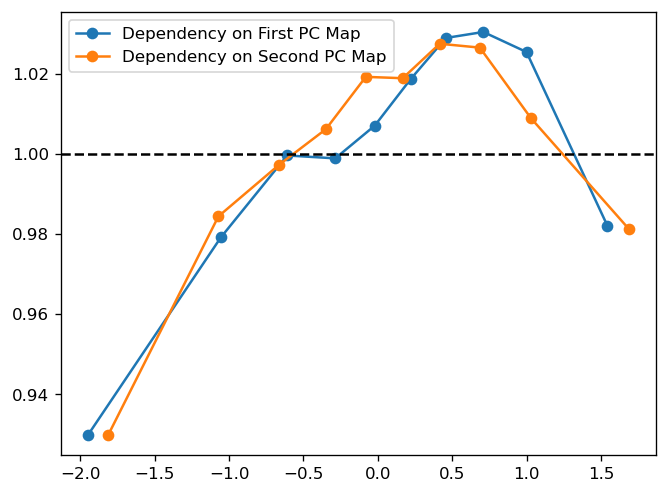

In [20]:
plt.figure(dpi = 120)
plt.plot(xBin, yBin, marker = 'o', label = 'Dependency on First PC Map')
# plt.plot(xBin20, yBin20, marker = 'o')
plt.plot(xBin_2, yBin_2, marker = 'o', label = 'Dependency on Second PC Map')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.legend()
plt.show()

## Gaussian Kernel Method

This is running much slower than the binning method. This takes ~ 82 sec compared to a ~ 1 sec runtime for binning. It should be noted that the totAll needs to only be calculated once. Change the limits back to 3 if you want I guess.

In [21]:
# xGaus = np.linspace(np.max([np.min(PC_Map), -3]), np.min([np.max(PC_Map), 3]), numBins)
# yGaus = []

# totAll = []
# for xi in xGaus:
#     totAll.append(np.sum(np.exp(-1*(((PC_Map - xi) / sigma)**2))))

# for i in range(len(xGaus)):
#     totCor = np.sum(detPixCounts * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGaus.append((totCor / totAll[i]) / aveDet)

In [22]:
# plt.figure(dpi = 120)
# plt.plot(xGaus, yGaus)
# plt.plot(xBin, yBin, marker = 'o')
# plt.plot(xBin20, yBin20, marker = 'o')
# plt.show()

# Remarks

These plots look relatively consistent in the range of the bins, but outside of that the behavior seems to diverge. However, if the number of bins is increased to 20-50, the trends match up more. This is definitely promising. Now, a couple different correction methods will be tested, and their impacts will be recorded.

First off, the interpolation method with the gaussian kernel method will be tested. Then, based on bins, a pointwise (not interpolation) fit will be done on the bin fit. Then, an interpolation fit will be done for the bin fit. Then, a linear and finally a polynomial fit will be done to the bin data.

We should also look at results from 20 bin fits to make it a bit different than the 10 bins, since the corrections will perfectly correct the 10 bins on some.

## Current Interpolation Method

In [23]:
# gausCorrFunc = inter.interp1d(xGaus, yGaus, bounds_error = False, fill_value = (yGaus[0], yGaus[-1]))

# countsGausCorr = detPixCounts / gausCorrFunc(PC_Map)

In [24]:
# yGausGausCorr = []

# for i in range(len(xGaus)):
#     totCor = np.sum(countsGausCorr * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGausGausCorr.append((totCor / totAll[i]) / aveDet)

In [25]:
# detStarGausCorr = countsGausCorr[sortInds[::1]]

# detBinsGausCorr = []

# for j in range(binsApproachNum):
#     detBinsGausCorr.append(detStarGausCorr[binIndLims[j]:binIndLims[j+1]])

# yBinGausCorr = []

# for j in range(binsApproachNum):
#     yBinGausCorr.append(np.sum(detBinsGausCorr[j]) / (aveDet * len(detBinsGausCorr[j])))

# yBinGausCorr = np.array(yBinGausCorr)

In [26]:
# detBinsGausCorr20 = []

# for j in range(20):
#     detBinsGausCorr20.append(detStarGausCorr[binIndLims20[j]:binIndLims20[j+1]])

# yBinGausCorr20 = []

# for j in range(20):
#     yBinGausCorr20.append(np.sum(detBinsGausCorr20[j]) / (aveDet * len(detBinsGausCorr20[j])))

# yBinGausCorr20 = np.array(yBinGausCorr20)

In [27]:
# plt.figure(dpi = 120)
# plt.plot(xGaus, yGausGausCorr)
# plt.plot(xBin, yBinGausCorr, marker = 'o')
# plt.plot(xBin20, yBinGausCorr20, marker = 'o')
# plt.axhline(y = 1, color = 'black', linestyle = '--')
# plt.show()

## Bin Point Correction

Each point will be given one of 10 possible corrections based on where it is. By definition, the bins approach should look perfect in this situation.

In [28]:
# countsBinCorr = np.copy(detPixCounts).astype(float)
# for i in range(len(pcBins)):
#     countsBinCorr[np.where((PC_Map >= pcBins[i][0]) & (PC_Map <= pcBins[i][-1]))[0]] = countsBinCorr[np.where((PC_Map >= pcBins[i][0]) & (PC_Map <= pcBins[i][-1]))[0]] / yBin[i]

In [29]:
# yGausBinCorr = []

# for i in range(len(xGaus)):
#     totCor = np.sum(countsBinCorr * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGausBinCorr.append((totCor / totAll[i]) / aveDet)

In [30]:
# detStarBinCorr = countsBinCorr[sortInds[::1]]

# detBinsBinCorr = []

# for j in range(binsApproachNum):
#     detBinsBinCorr.append(detStarBinCorr[binIndLims[j]:binIndLims[j+1]])

# yBinBinCorr = []

# for j in range(binsApproachNum):
#     yBinBinCorr.append(np.sum(detBinsBinCorr[j]) / (aveDet * len(detBinsBinCorr[j])))

# yBinBinCorr = np.array(yBinBinCorr)

In [31]:
# detBinsBinCorr20 = []

# for j in range(20):
#     detBinsBinCorr20.append(detStarBinCorr[binIndLims20[j]:binIndLims20[j+1]])

# yBinBinCorr20 = []

# for j in range(20):
#     yBinBinCorr20.append(np.sum(detBinsBinCorr20[j]) / (aveDet * len(detBinsBinCorr20[j])))

# yBinBinCorr20 = np.array(yBinBinCorr20)

In [32]:
# plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinCorr)
# plt.plot(xBin, yBinBinCorr, marker = 'o')
# plt.plot(xBin20, yBinBinCorr20, marker = 'o')
# plt.axhline(y = 1, color = 'black', linestyle = '--')
# plt.show()

## Bin Line Correction

This will be a linear fit. Maybe consider bootstrap sampling some uncertainties for the bins for a later test as well.

In [33]:
# p = np.polyfit(xBin, yBin, 1)

In [34]:
# countsBinLinCorr = detPixCounts / (p[0] * PC_Map + p[1])

In [35]:
# yGausBinLinCorr = []

# for i in range(len(xGaus)):
#     totCor = np.sum(countsBinLinCorr * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGausBinLinCorr.append((totCor / totAll[i]) / aveDet)

In [36]:
# detStarBinLinCorr = countsBinLinCorr[sortInds[::1]]

# detBinsBinLinCorr = []

# for j in range(binsApproachNum):
#     detBinsBinLinCorr.append(detStarBinLinCorr[binIndLims[j]:binIndLims[j+1]])

# yBinBinLinCorr = []

# for j in range(binsApproachNum):
#     yBinBinLinCorr.append(np.sum(detBinsBinLinCorr[j]) / (aveDet * len(detBinsBinLinCorr[j])))

# yBinBinLinCorr = np.array(yBinBinLinCorr)

In [37]:
# detBinsBinLinCorr20 = []

# for j in range(20):
#     detBinsBinLinCorr20.append(detStarBinLinCorr[binIndLims20[j]:binIndLims20[j+1]])

# yBinBinLinCorr20 = []

# for j in range(20):
#     yBinBinLinCorr20.append(np.sum(detBinsBinLinCorr20[j]) / (aveDet * len(detBinsBinLinCorr20[j])))

# yBinBinLinCorr20 = np.array(yBinBinLinCorr20)

In [38]:
# plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinLinCorr)
# plt.plot(xBin, yBinBinLinCorr, marker = 'o')
# plt.plot(xBin20, yBinBinLinCorr20, marker = 'o')
# plt.axhline(y = 1, color = 'black', linestyle = '--')
# plt.show()

In [39]:
# 2d histogram

first_pc_bin_lims = [pcBins[0][0]]
for i in range(len(pcBins)):
    first_pc_bin_lims.append(pcBins[i][-1])

second_pc_bin_lims = [pcBins_2[0][0]]
for i in range(len(pcBins_2)):
    second_pc_bin_lims.append(pcBins_2[i][-1])

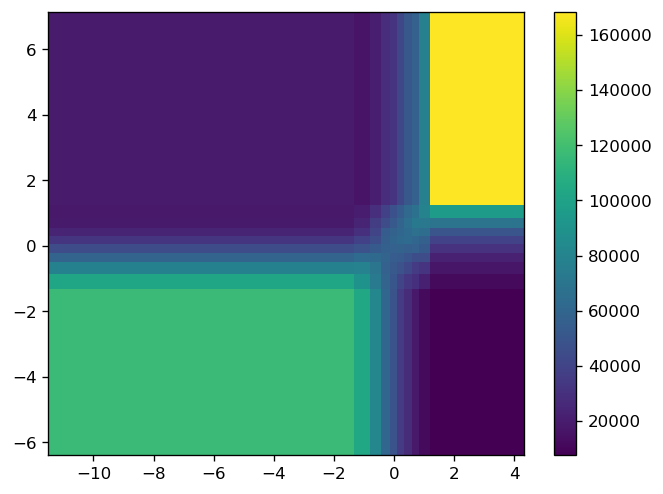

In [40]:
plt.figure(dpi = 120)
bins = plt.hist2d(PC_Map, PC_Map_2, bins = (first_pc_bin_lims, second_pc_bin_lims))
bins = bins[0]
plt.colorbar()
plt.show()

In [41]:
normWeights = np.ones_like(PC_Map)
for i in np.arange(len(first_pc_bin_lims) - 1):
    for j in np.arange(len(second_pc_bin_lims) - 1):
        inds = np.where((PC_Map <= first_pc_bin_lims[i + 1]) & (PC_Map >= first_pc_bin_lims[i]) & (PC_Map_2 <= second_pc_bin_lims[j + 1]) & (PC_Map_2 >= second_pc_bin_lims[j]))[0]
        normWeights[inds] = 1 / (bins[i][j])

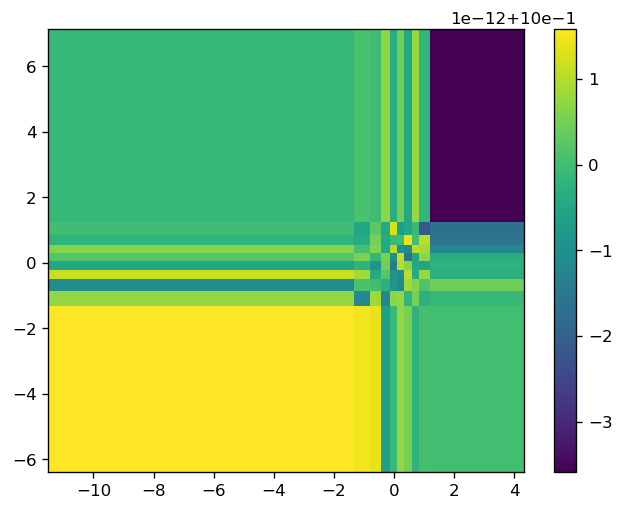

In [42]:
plt.figure(dpi = 120)
plt.hist2d(PC_Map, PC_Map_2, bins = (first_pc_bin_lims, second_pc_bin_lims), weights = normWeights)
plt.colorbar()
plt.show()

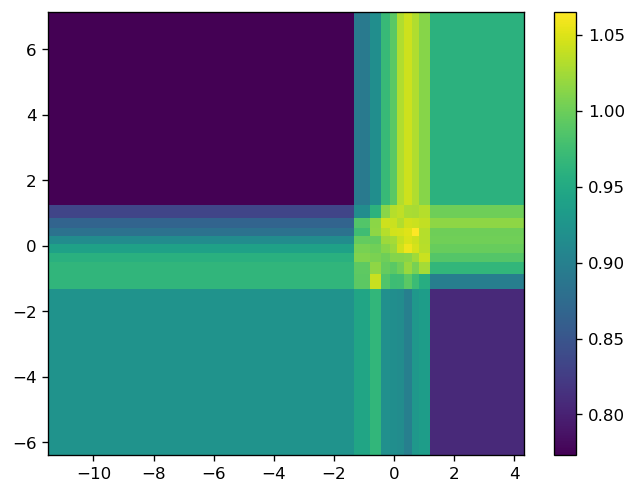

In [43]:
plt.figure(dpi = 120)
countBins = plt.hist2d(PC_Map, PC_Map_2, bins = (first_pc_bin_lims, second_pc_bin_lims), weights = detPixCounts * normWeights / np.average(detPixCounts))
countBins = countBins[0]
plt.colorbar()
plt.show()

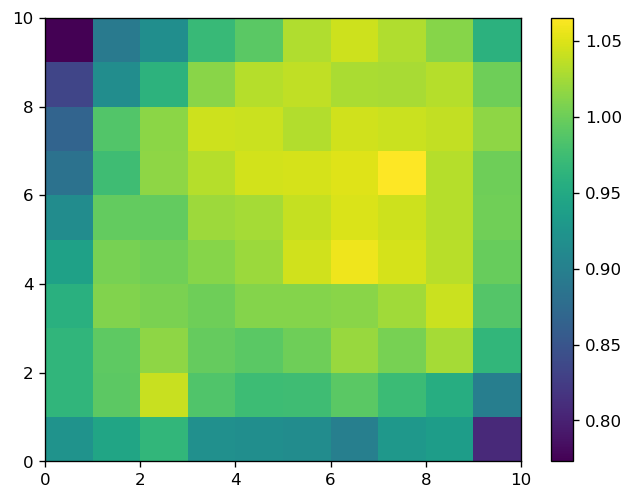

In [44]:
xHist = np.linspace(0, 10, 10)
yHist = np.linspace(0, 10, 10)
mesh = np.meshgrid(xHist, yHist)
xHist = mesh[0].flatten()
yHist = mesh[1].flatten()
countBins = (countBins.T).flatten()

plt.figure(dpi = 120)
origCountBins = plt.hist2d(xHist, yHist, weights = countBins)
origCountBins = origCountBins[0].flatten()
plt.colorbar()
plt.show()

## Beatdown Method Check

In [66]:
binCorrFunc = inter.interp1d(xBin, yBin, bounds_error = False, fill_value = (yBin[0], yBin[-1]))

countsCorr = secondCountsCorr / (np.max([binCorrFunc(PC_Map), 0.1 * np.ones_like(PC_Map)], axis = 0))

In [67]:
detStarBinInterCorr = countsCorr[sortInds[::1]]

detBinsBinInterCorr = []

for j in range(binsApproachNum):
    detBinsBinInterCorr.append(detStarBinInterCorr[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorr = []

for j in range(binsApproachNum):
    yBinBinInterCorr.append(np.sum(detBinsBinInterCorr[j]) / (aveDet * len(detBinsBinInterCorr[j])))

yBin = np.array(yBinBinInterCorr)

In [68]:
detStarBinInterCorr_2 = countsCorr[sortInds_2[::1]]

detBinsBinInterCorr_2 = []

for j in range(binsApproachNum):
    detBinsBinInterCorr_2.append(detStarBinInterCorr_2[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorr_2 = []

for j in range(binsApproachNum):
    yBinBinInterCorr_2.append(np.sum(detBinsBinInterCorr_2[j]) / (aveDet * len(detBinsBinInterCorr_2[j])))

yBin_2 = np.array(yBinBinInterCorr_2)

In [69]:
secondBinCorrFunc = inter.interp1d(xBin_2, yBin_2, bounds_error = False, fill_value = (yBin_2[0], yBin_2[-1]))

secondCountsCorr = countsCorr / (np.max([secondBinCorrFunc(PC_Map_2), 0.1 * np.ones_like(PC_Map_2)], axis = 0))

In [70]:
detStarBinInterCorr = secondCountsCorr[sortInds[::1]]

detBinsBinInterCorr = []

for j in range(binsApproachNum):
    detBinsBinInterCorr.append(detStarBinInterCorr[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorrSecond = []

for j in range(binsApproachNum):
    yBinBinInterCorrSecond.append(np.sum(detBinsBinInterCorr[j]) / (aveDet * len(detBinsBinInterCorr[j])))

yBin = np.array(yBinBinInterCorrSecond)

In [71]:
detStarBinInterCorr_2 = secondCountsCorr[sortInds_2[::1]]

detBinsBinInterCorr_2 = []

for j in range(binsApproachNum):
    detBinsBinInterCorr_2.append(detStarBinInterCorr_2[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorr_2 = []

for j in range(binsApproachNum):
    yBinBinInterCorr_2.append(np.sum(detBinsBinInterCorr_2[j]) / (aveDet * len(detBinsBinInterCorr_2[j])))

yBin_2 = np.array(yBinBinInterCorr_2)

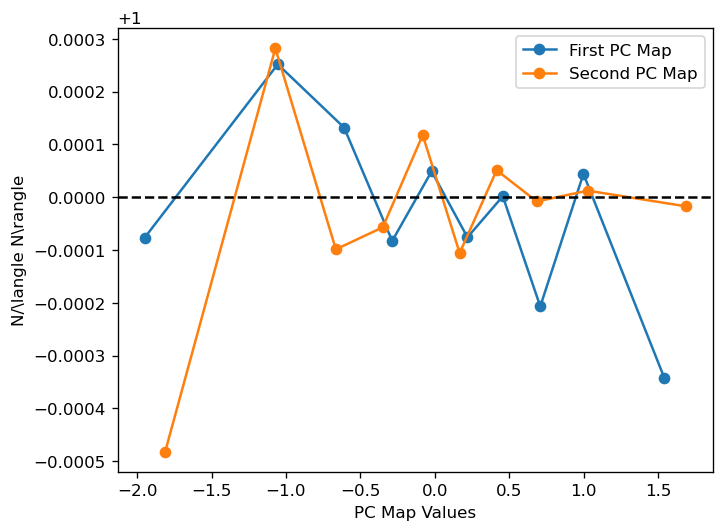

In [72]:
plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinInterCorr)
# plt.plot(xBin, yBinBinInterCorr, marker = 'o')
# plt.plot(xBin20, yBinBinInterCorr20, marker = 'o')
plt.plot(xBin, yBin, marker = 'o', label = 'First PC Map')
plt.plot(xBin_2, yBin_2, marker = 'o', label = 'Second PC Map')
plt.legend()
plt.xlabel('PC Map Values')
plt.ylabel(r'N/\langle N\rangle')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

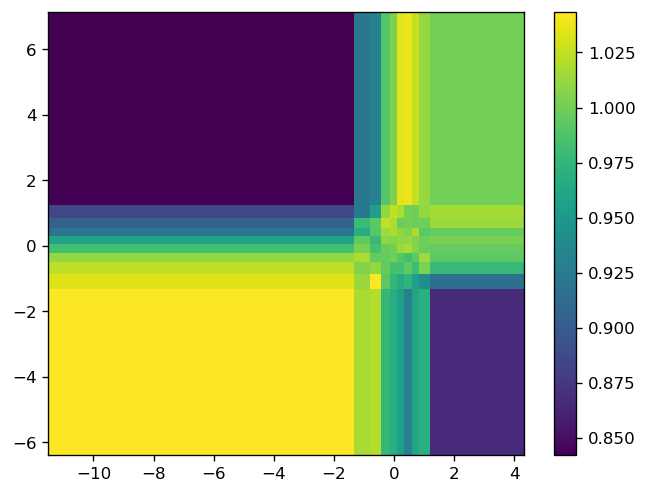

In [73]:
plt.figure(dpi = 120)
countBins = plt.hist2d(PC_Map, PC_Map_2, bins = (first_pc_bin_lims, second_pc_bin_lims), weights = secondCountsCorr * normWeights / np.average(detPixCounts))
countBins = countBins[0]
plt.colorbar()
plt.show()

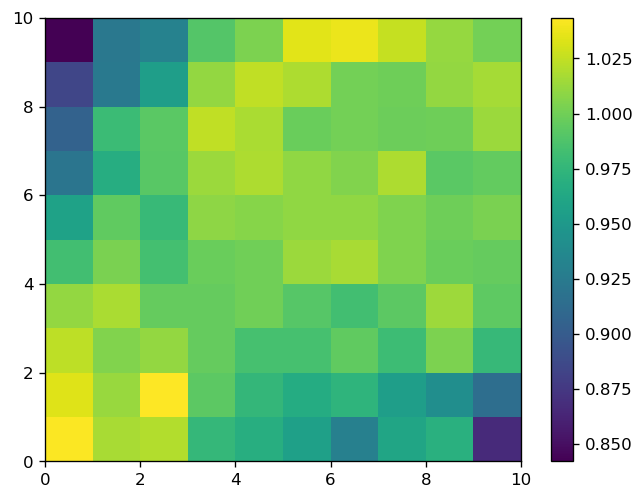

In [74]:
xHist = np.linspace(0, 10, 10)
yHist = np.linspace(0, 10, 10)
mesh = np.meshgrid(xHist, yHist)
xHist = mesh[0].flatten()
yHist = mesh[1].flatten()
countBins = (countBins.T).flatten()

plt.figure(dpi = 120)
corrCountBins = plt.hist2d(xHist, yHist, weights = countBins)
corrCountBins = corrCountBins[0].flatten()
plt.colorbar()
plt.show()

In [77]:
np.std(corrCountBins) / np.average(corrCountBins)

0.03607772326902379

In [78]:
np.std(origCountBins) / np.average(origCountBins)

0.056051066647348935

## Bin Interpolation Fit

Issues if above code is run.

In [ ]:
binCorrFunc = inter.interp1d(xBin, yBin, bounds_error = False, fill_value = 'extrapolate')#(yBin[0], yBin[-1]))

countsBinInterCorr = detPixCounts / (np.max([binCorrFunc(PC_Map), 0.1 * np.ones_like(PC_Map)], axis = 0))

In [ ]:
# yGausBinInterCorr = []

# for i in range(len(xGaus)):
#     totCor = np.sum(countsBinInterCorr * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGausBinInterCorr.append((totCor / totAll[i]) / aveDet)

In [ ]:
detStarBinInterCorr = countsBinInterCorr[sortInds[::1]]

detBinsBinInterCorr = []

for j in range(binsApproachNum):
    detBinsBinInterCorr.append(detStarBinInterCorr[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorr = []

for j in range(binsApproachNum):
    yBinBinInterCorr.append(np.sum(detBinsBinInterCorr[j]) / (aveDet * len(detBinsBinInterCorr[j])))

yBinBinInterCorr = np.array(yBinBinInterCorr)

In [ ]:
detBinsBinInterCorr20 = []

for j in range(20):
    detBinsBinInterCorr20.append(detStarBinInterCorr[binIndLims20[j]:binIndLims20[j+1]])

yBinBinInterCorr20 = []

for j in range(20):
    yBinBinInterCorr20.append(np.sum(detBinsBinInterCorr20[j]) / (aveDet * len(detBinsBinInterCorr20[j])))

yBinBinInterCorr20 = np.array(yBinBinInterCorr20)

In [ ]:
detStarBinInterCorr_2 = countsBinInterCorr[sortInds_2[::1]]

detBinsBinInterCorr_2 = []

for j in range(binsApproachNum):
    detBinsBinInterCorr_2.append(detStarBinInterCorr_2[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorr_2 = []

for j in range(binsApproachNum):
    yBinBinInterCorr_2.append(np.sum(detBinsBinInterCorr_2[j]) / (aveDet * len(detBinsBinInterCorr_2[j])))

yBinBinInterCorr_2 = np.array(yBinBinInterCorr_2)

In [ ]:
plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinInterCorr)
plt.plot(xBin, yBinBinInterCorr, marker = 'o', label = 'Dependency on First Post Correction')
plt.legend()
# plt.plot(xBin20, yBinBinInterCorr20, marker = 'o')
plt.xlabel('PC Map Values')
plt.ylabel(r'N/\langle N\rangle')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

In [ ]:
plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinInterCorr)
# plt.plot(xBin, yBinBinInterCorr, marker = 'o')
# plt.plot(xBin20, yBinBinInterCorr20, marker = 'o')
plt.plot(xBin_2, yBinBinInterCorr_2, marker = 'o', label = 'Second PC Map Post Correction')
plt.plot(xBin_2, yBin_2, marker = 'o', label = 'Second PC Map Pre Correction')
plt.legend()
plt.xlabel('PC Map Values')
plt.ylabel(r'N/\langle N\rangle')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

In [ ]:
secondCorrection = inter.interp1d(xBin_2, yBinBinInterCorr_2, bounds_error = False, fill_value = 'extrapolate')

secondCountsBinInterCorr = countsBinInterCorr / (np.max([secondCorrection(PC_Map_2), 0.1 * np.ones_like(PC_Map_2)], axis = 0))

In [ ]:
detStarBinInterCorr = secondCountsBinInterCorr[sortInds[::1]]

detBinsBinInterCorr = []

for j in range(binsApproachNum):
    detBinsBinInterCorr.append(detStarBinInterCorr[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorrSecond = []

for j in range(binsApproachNum):
    yBinBinInterCorrSecond.append(np.sum(detBinsBinInterCorr[j]) / (aveDet * len(detBinsBinInterCorr[j])))

yBinBinInterCorrSecond = np.array(yBinBinInterCorrSecond)

In [ ]:
detStarBinInterCorr_2 = secondCountsBinInterCorr[sortInds_2[::1]]

detBinsBinInterCorr_2 = []

for j in range(binsApproachNum):
    detBinsBinInterCorr_2.append(detStarBinInterCorr_2[binIndLims[j]:binIndLims[j+1]])

yBinBinInterCorrSecond_2 = []

for j in range(binsApproachNum):
    yBinBinInterCorrSecond_2.append(np.sum(detBinsBinInterCorr_2[j]) / (aveDet * len(detBinsBinInterCorr_2[j])))

yBinBinInterCorrSecond_2 = np.array(yBinBinInterCorrSecond_2)

In [ ]:
plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinInterCorr)
plt.plot(xBin, yBinBinInterCorr, marker = 'o', label = 'First PC Pre Second Correction')
plt.plot(xBin, yBinBinInterCorrSecond, marker = 'o', label = 'First PC Post Second Correction')
# plt.plot(xBin_2, yBinBinInterCorrSecond_2, marker = 'o', label = 'Corrected Second Property')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinInterCorr)
# plt.plot(xBin, yBinBinInterCorr, marker = 'o', label = 'First PC Pre Second Correction')
# plt.plot(xBin, yBinBinInterCorrSecond, marker = 'o', label = 'First PC Post Second Correction')
plt.plot(xBin_2, yBinBinInterCorrSecond_2, marker = 'o', label = 'Corrected Second Property')
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.legend()
plt.show()

## Bin Parabola Fit

In [ ]:
# p = np.polyfit(xBin, yBin, 2)

In [ ]:
# countsBinParaCorr = detPixCounts / (p[0] * (PC_Map**2) + p[1] * PC_Map + p[2])

In [ ]:
# yGausBinParaCorr = []

# for i in range(len(xGaus)):
#     totCor = np.sum(countsBinParaCorr * np.exp(-1*(((PC_Map - xGaus[i]) / sigma)**2)))
#     yGausBinParaCorr.append((totCor / totAll[i]) / aveDet)

In [ ]:
# detStarBinParaCorr = countsBinParaCorr[sortInds[::1]]

# detBinsBinParaCorr = []

# for j in range(binsApproachNum):
#     detBinsBinParaCorr.append(detStarBinParaCorr[binIndLims[j]:binIndLims[j+1]])

# yBinBinParaCorr = []

# for j in range(binsApproachNum):
#     yBinBinParaCorr.append(np.sum(detBinsBinParaCorr[j]) / (aveDet * len(detBinsBinInterCorr[j])))

# yBinBinParaCorr = np.array(yBinBinParaCorr)

In [ ]:
# detBinsBinParaCorr20 = []

# for j in range(20):
#     detBinsBinParaCorr20.append(detStarBinParaCorr[binIndLims20[j]:binIndLims20[j+1]])

# yBinBinParaCorr20 = []

# for j in range(20):
#     yBinBinParaCorr20.append(np.sum(detBinsBinParaCorr20[j]) / (aveDet * len(detBinsBinParaCorr20[j])))

# yBinBinParaCorr20 = np.array(yBinBinParaCorr20)

In [ ]:
# plt.figure(dpi = 120)
# plt.plot(xGaus, yGausBinParaCorr)
# plt.plot(xBin, yBinBinParaCorr, marker = 'o')
# plt.plot(xBin20, yBinBinParaCorr20, marker = 'o')
# plt.axhline(y = 1, color = 'black', linestyle = '--')
# plt.show()

# Some Separability Tests

In [2]:
binsApproachNum = 10

In [121]:
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
mesh = np.meshgrid(x, y)
x = mesh[0].flatten()
y = mesh[1].flatten()

In [122]:
def sepProbDet(x, y):
    return(x*y)#(0.5*x + 0.5) * (0.5*y + 0.5))

In [123]:
def notSepProbDet(x, y):
    return(0.5*(x + y))

In [124]:
probs = sepProbDet(x, y)

In [125]:
detChance = np.random.rand(len(x))

In [126]:
det = np.zeros_like(x)
det[np.where(detChance <= probs)[0]] = 1

In [127]:
binIndLims = [0]

for j in range(binsApproachNum):
    binIndLims.append(int((len(x) - binIndLims[-1]) / (binsApproachNum - j)) + (binIndLims[-1]))

sortInds = x.argsort()
x_Sort = x[sortInds[::1]]
detStarTemp = det[sortInds[::1]]

detBins = []
xBins = []

for j in range(binsApproachNum):
    detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
    xBins.append(x_Sort[binIndLims[j]:binIndLims[j+1]])
    
aveDet = np.sum(det) / len(det)

y_plt_Bin = []
x_plt_Bin = []

for j in range(binsApproachNum):
    y_plt_Bin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
    x_plt_Bin.append(np.sum(xBins[j]) / len(xBins[j]))

x_plt_Bin = np.array(x_plt_Bin)
y_plt_Bin = np.array(y_plt_Bin)

In [128]:
sortInds_2 = y.argsort()
y_Sort = y[sortInds_2[::1]]
y_detStarTemp = det[sortInds_2[::1]]

yDetBins = []
yBins = []

for j in range(binsApproachNum):
    yDetBins.append(y_detStarTemp[binIndLims[j]:binIndLims[j+1]])
    yBins.append(y_Sort[binIndLims[j]:binIndLims[j+1]])

y_plt_Bin_y = []
x_plt_Bin_y = []

for j in range(binsApproachNum):
    y_plt_Bin_y.append(np.sum(yDetBins[j]) / (aveDet * len(yDetBins[j])))
    x_plt_Bin_y.append(np.sum(yBins[j]) / len(yBins[j]))

x_plt_Bin_y = np.array(x_plt_Bin_y)
y_plt_Bin_y = np.array(y_plt_Bin_y)

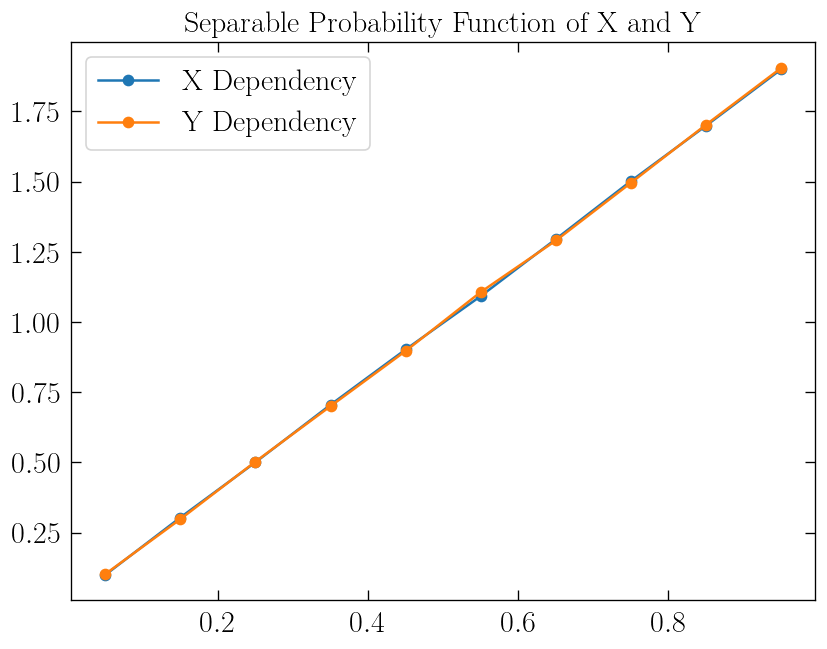

In [129]:
plt.figure(dpi = 120)
plt.plot(x_plt_Bin, y_plt_Bin, marker = 'o', label = 'X Dependency')
plt.plot(x_plt_Bin_y, y_plt_Bin_y, marker = 'o', label = 'Y Dependency')
plt.title('Separable Probability Function of X and Y')
plt.legend()
plt.show()

In [194]:
binCorrFunc = inter.interp1d(x_plt_Bin, y_plt_Bin, bounds_error = False, fill_value = (y_plt_Bin[0], y_plt_Bin[-1]))

detCorr = newDetCorr / (np.max([binCorrFunc(x), 0.1 * np.ones_like(x)], axis = 0))

In [195]:
detStarTemp = detCorr[sortInds[::1]]

detBins = []

for j in range(binsApproachNum):
    detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])

y_plt_Bin = []

for j in range(binsApproachNum):
    y_plt_Bin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

x_plt_Bin = np.array(x_plt_Bin)

In [196]:
y_detStarTemp = detCorr[sortInds_2[::1]]

yDetBins = []

for j in range(binsApproachNum):
    yDetBins.append(y_detStarTemp[binIndLims[j]:binIndLims[j+1]])

y_plt_Bin_y = []

for j in range(binsApproachNum):
    y_plt_Bin_y.append(np.sum(yDetBins[j]) / (aveDet * len(yDetBins[j])))

x_plt_Bin_y = np.array(x_plt_Bin_y)

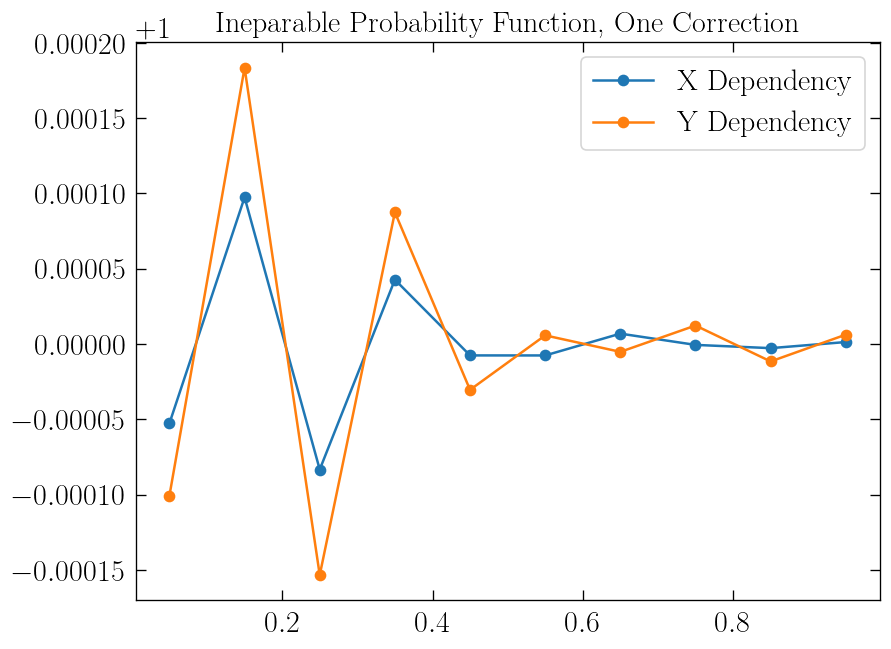

In [197]:
plt.figure(dpi = 120)
plt.plot(x_plt_Bin, y_plt_Bin, marker = 'o', label = 'X Dependency')
plt.plot(x_plt_Bin_y, y_plt_Bin_y, marker = 'o', label = 'Y Dependency')
plt.title('Ineparable Probability Function, One Correction')
plt.legend()
plt.show()

In [198]:
binCorrFunc = inter.interp1d(x_plt_Bin_y, y_plt_Bin_y, bounds_error = False, fill_value = (y_plt_Bin_y[0], y_plt_Bin_y[-1]))

newDetCorr = detCorr / (np.max([binCorrFunc(y), 0.1 * np.ones_like(y)], axis = 0))

In [199]:
detStarTemp = newDetCorr[sortInds[::1]]

detBins = []

for j in range(binsApproachNum):
    detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])

y_plt_Bin = []

for j in range(binsApproachNum):
    y_plt_Bin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

x_plt_Bin = np.array(x_plt_Bin)

In [200]:
y_detStarTemp = newDetCorr[sortInds_2[::1]]

yDetBins = []

for j in range(binsApproachNum):
    yDetBins.append(y_detStarTemp[binIndLims[j]:binIndLims[j+1]])

y_plt_Bin_y = []

for j in range(binsApproachNum):
    y_plt_Bin_y.append(np.sum(yDetBins[j]) / (aveDet * len(yDetBins[j])))

x_plt_Bin_y = np.array(x_plt_Bin_y)

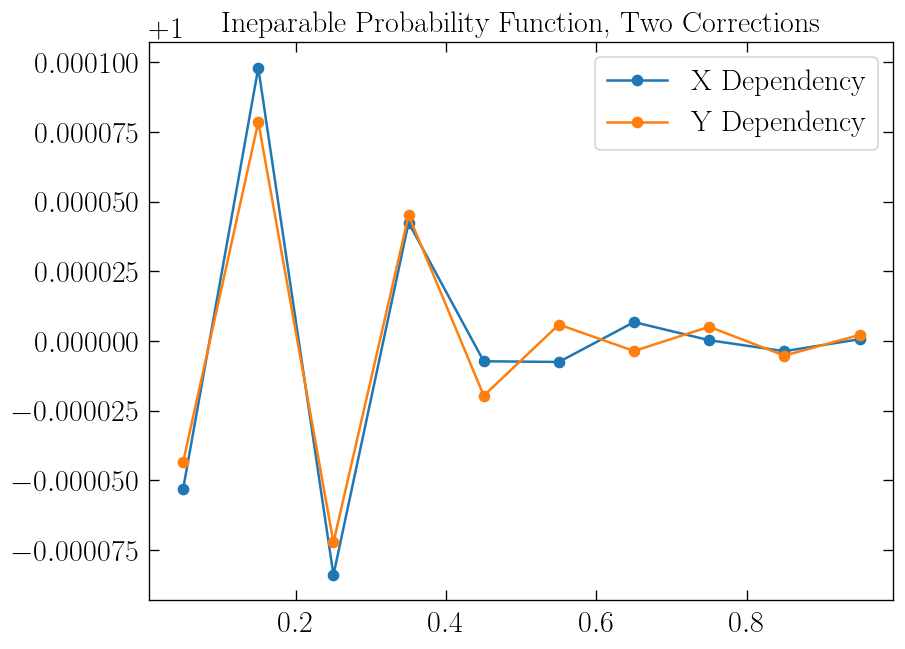

In [201]:
plt.figure(dpi = 120)
plt.plot(x_plt_Bin, y_plt_Bin, marker = 'o', label = 'X Dependency')
plt.plot(x_plt_Bin_y, y_plt_Bin_y, marker = 'o', label = 'Y Dependency')
plt.title('Ineparable Probability Function, Two Corrections')
plt.legend()
plt.show()

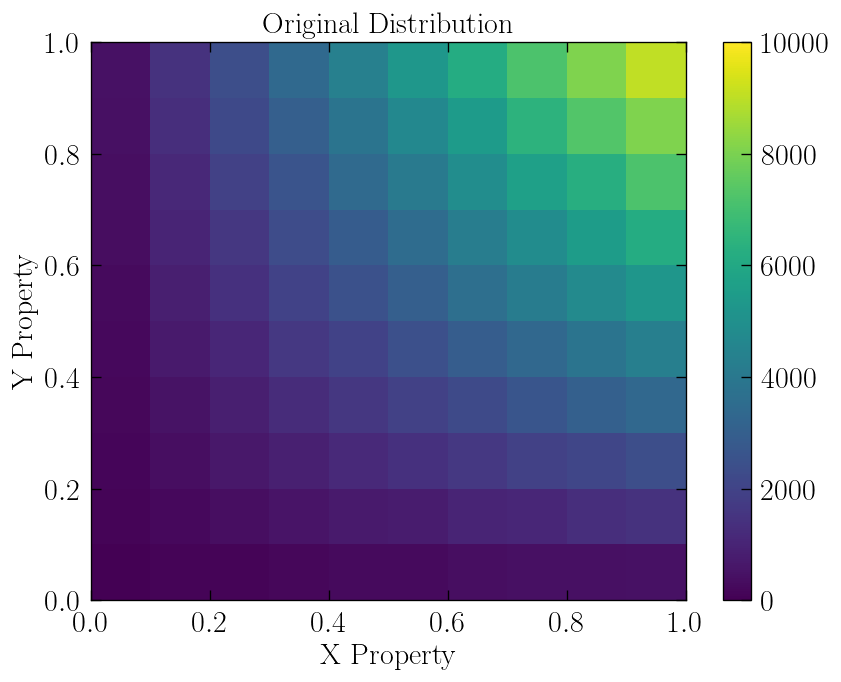

In [202]:
plt.figure(dpi = 120)
plt.hist2d(x, y, weights = det, vmin = 0, vmax = 10000)
plt.colorbar()
plt.xlabel('X Property')
plt.ylabel('Y Property')
plt.title('Original Distribution')
plt.show()

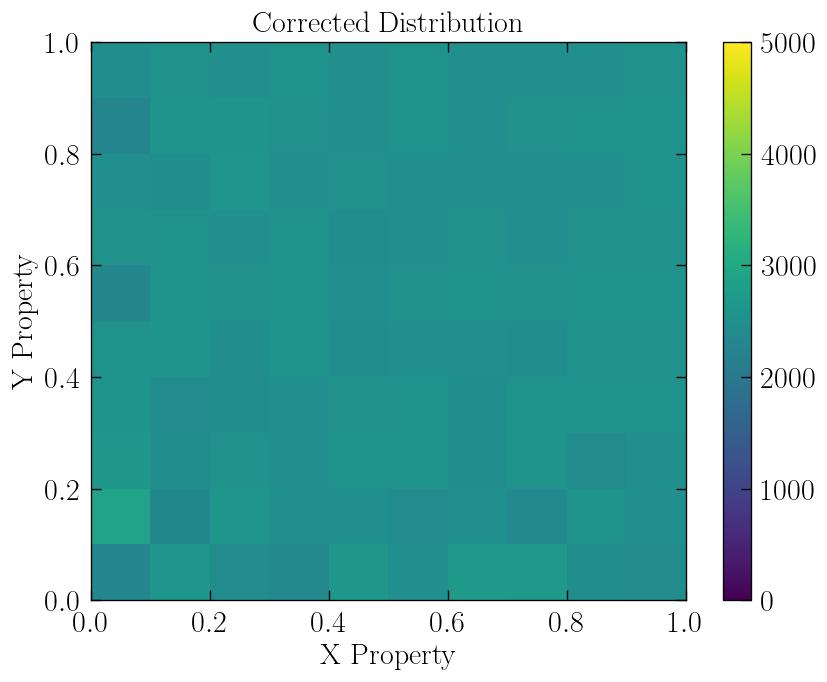

In [204]:
plt.figure(dpi = 120)
ch = plt.hist2d(x, y, weights = newDetCorr, vmin = 0, vmax = 5000)
plt.colorbar()
plt.xlabel('X Property')
plt.ylabel('Y Property')
plt.title('Corrected Distribution')
plt.show()

In [205]:
# inDet = np.copy(det)
# inNewDetCorr = np.copy(newDetCorr)

In [72]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [73]:
import matplotlib.style
import matplotlib

matplotlib.style.use('des_dr1')

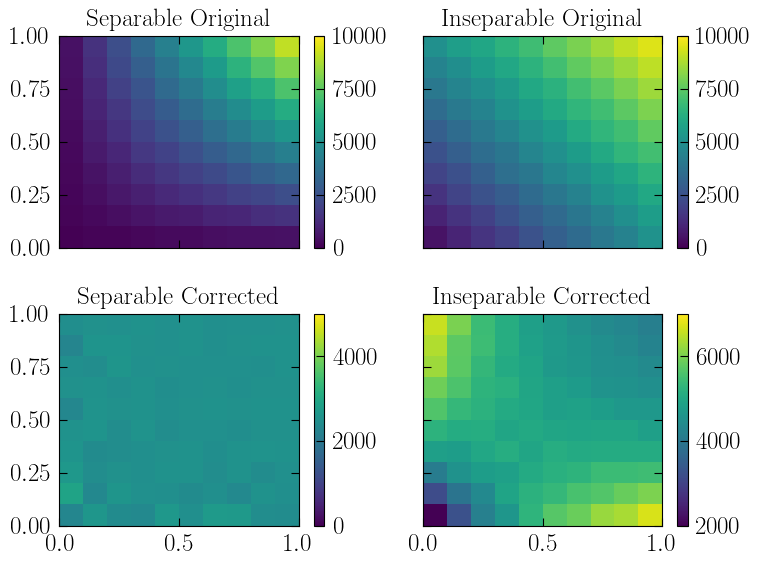

In [211]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, tight_layout=True)
axes_arr = [(0,0), (0,1), (1,0), (1,1)]
det_arr = [det, inDet, newDetCorr, inNewDetCorr]
vmin_arr = [0, 0, 0, 2000]
vmax_arr = [10000, 10000, 5000, 7000]
titles = ['Separable Original', 'Inseparable Original', 'Separable Corrected', 'Inseparable Corrected']
for j in range(len(det_arr)):
    im = axs[axes_arr[j][0],axes_arr[j][1]].hist2d(x, y, weights = det_arr[j], vmin = vmin_arr[j], vmax = vmax_arr[j])
    #if j%2 == 1:
    axs[axes_arr[j][0],axes_arr[j][1]].set_title(titles[j])
    fig.colorbar(im[3], ax = axs[axes_arr[j][0],axes_arr[j][1]])
    
# fig.supxlabel('X Survey Property Percentile')
# fig.supylabel('Y Survey Property Percentile')
# fig.suptitle('Separability Simulated Tests')
plt.show()

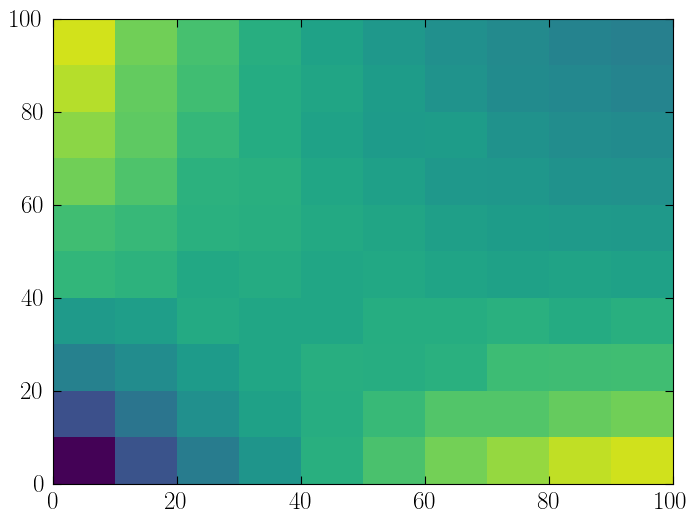

In [355]:
# imDet, _, __, ___ = plt.hist2d(x * 100, y * 100, weights = det, vmin = 0, vmax = 10000)
# imInDet, _, __, ___ = plt.hist2d(x * 100, y * 100, weights = inDet, vmin = 0, vmax = 10000)
# imDetCorr, _, __, ___ = plt.hist2d(x * 100, y * 100, weights = newDetCorr, vmin = 2000, vmax = 7000)
# imInDetCorr, _, __, ___ = plt.hist2d(x * 100, y * 100, weights = inNewDetCorr, vmin = 2000, vmax = 7000)

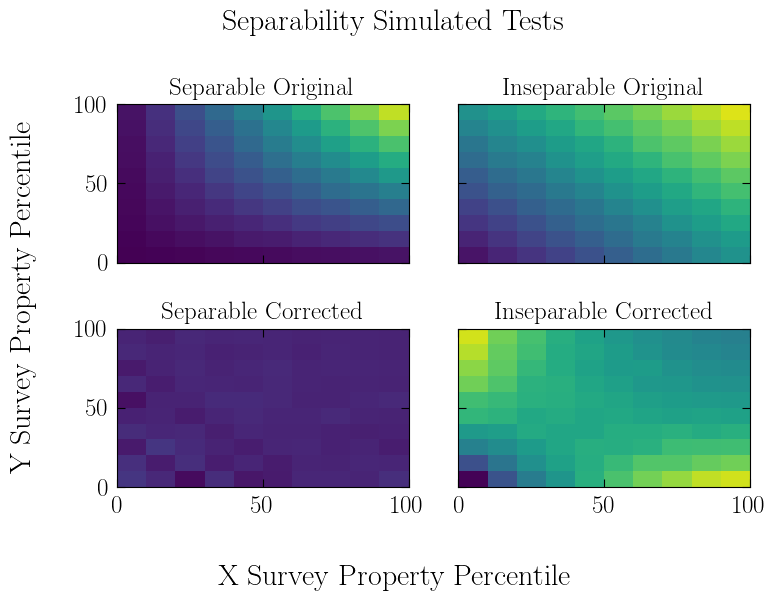

In [369]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, tight_layout=True)

axs[0][0].hist2d(x * 100, y * 100, weights = det, vmin = 0, vmax = 10000)
# axs[0][0].imshow(imDet, vmin = 0, vmax = 10000)
axs[0][0].set_title('Separable Original')

axs[1][0].hist2d(x * 100, y * 100, weights = newDetCorr, vmin = 2000, vmax = 7000)
# axs[1][0].imshow(imDetCorr, vmin = 2000, vmax = 7000)
axs[1][0].set_title('Separable Corrected')

# As well as define normalization of the colors
axs[0][1].hist2d(x * 100, y * 100, weights = inDet, vmin = 0, vmax = 10000)
# imTop = axs[0][1].imshow(imInDet, vmin = 0, vmax = 10000)
axs[0][1].set_title('Inseparable Original')
# plt.colorbar(imTop, ax=axs[0][1])

# We can also define custom numbers of bins for each axis
axs[1][1].hist2d(x * 100, y * 100, weights = inNewDetCorr, vmin = 2000, vmax = 7000)
# imBot = axs[1][1].imshow(imInDetCorr, vmin = 2000, vmax = 7000)
axs[1][1].set_title('Inseparable Corrected')
# plt.colorbar(imBot, ax=axs[1][1])

fig.supxlabel('X Survey Property Percentile')

fig.supylabel('Y Survey Property Percentile')

fig.suptitle('Separability Simulated Tests')

plt.tight_layout()

plt.show()

## Neural Network Approach

In [ ]:
# import tensorflow as tf

In [ ]:
# net = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(5, activation = 'relu', input_dim=2),
#     #tf.keras.layers.Dense(10, activation='relu'),
#     tf.keras.layers.Dense(5, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
# net.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# xTrain = np.append(np.atleast_2d(x), np.atleast_2d(y), axis = 0).T

In [ ]:
# net.fit(xTrain, det, epochs=10, batch_size=500)

In [ ]:
# probs = net.predict(xTrain)

In [ ]:
# detCorr = det / probs[:,0]

In [ ]:
# plt.figure(dpi = 120)
# plt.hist2d(x, y, weights = det)
# plt.colorbar()
# plt.xlabel('X Property')
# plt.ylabel('Y Property')
# plt.title('Original Distribution')
# plt.show()

In [ ]:
# plt.figure(dpi = 120)
# plt.hist2d(x, y, weights = detCorr)
# plt.colorbar()
# plt.xlabel('X Property')
# plt.ylabel('Y Property')
# plt.title('Corrected Distribution')
# plt.show()

In [ ]:
# plt.figure(dpi = 120)
# plt.hist2d(x, y, weights = probs[:,0])
# plt.colorbar()
# plt.xlabel('X Property')
# plt.ylabel('Y Property')
# plt.title('Probability Distribution')
# plt.show()

## Quick PCA Check

In [ ]:
# condMaps = []

# # This loops over every condition file
# for condFile in test1aCondFiles[0:2]:
#     condData = fitsio.read(condFile) # This reads in the data
#     condMaps.append(condData['SIGNAL'][0:1000]) # Only stores the values that are in pixels with injections

# condMaps = np.array(condMaps, dtype = object) # Converts to an array

# means = []
# stds = []
# # This will hold every standardized map
# stanMaps = []
# # This standardizes every map as a first step of PCA
# for j in range(len(condMaps)):
#     # Store mean and std dev for later use.
#     means.append(np.average(condMaps[j]))
#     stds.append(np.std(condMaps[j]))
#     stanMaps.append((condMaps[j] - np.average(condMaps[j])) / np.std(condMaps[j]))

# stanMaps = np.array(stanMaps)

# # This gives the covariance matrix of the standardized maps
# # Bias is true since the variance of each individual standardized map should be 1
# cov = np.cov(stanMaps.astype(float), bias = True)

# # This gives the eigenvalues and vectors of the covariance matrix
# evalues, evectors = np.linalg.eig(cov)

# # This cuts after the specified percentage of the variance has been achieved
# for j in range(len(evalues)):
#     if np.sum(evalues[0:j+1]) / np.sum(evalues) >= perVar:
#         cutoff = j + 1
#         break
# featVec = evectors[0:cutoff]

# redMaps = np.matmul(featVec, stanMaps) # Reduces the maps to PCA maps

# # Standard deviations will once more be stored for later use.
# # Maps are reduced to standard deviation of 1 for consistent x values in the following steps.
# redStds = []
# for j in np.arange(len(redMaps)):
#     redStds.append(np.std(redMaps[j]))
#     redMaps[j] = redMaps[j]/np.std(redMaps[j])

In [ ]:
# plt.figure(dpi = 120)
# plt.scatter(stanMaps[0], stanMaps[1], s = 0.0000001)
# plt.show()

In [ ]:
# plt.figure(dpi = 120)
# plt.scatter(redMaps[0], redMaps[1], s = 0.0000001)
# plt.show()